# Creating a collection of Physical Exam terms

This notebook covers the creation of references terms for CVD and CHD. This is done through the following steps:
1. Creation of a dictionary based on the `Diagnosis` and `Problem List` subject areas
2. Applying `fuzzy` or `spacy` based searches to get suitable thresholds.
3. Implement a search based on a selected threshold.
4. Save the search results and use as dictionary for later filtering.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from dotenv import load_dotenv
load_dotenv("../.env")  # take environment variables
PROJECT_ROOT = os.environ.get("PROJECT_ROOT")
sys.path.append(PROJECT_ROOT)
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from tqdm import tqdm
from datetime import datetime

import utils.PATHS as PATHS
import utils.utils as utils
# import utils.emr_utils as emr_utils
# import utils.load_utils as load_utils

In [3]:
dia_fp_list = glob(os.path.join(PATHS.DIAGNOSIS, "*.csv"))

# general labs dataframe
df_list = [pd.read_csv(path, low_memory=False) for path in tqdm(dia_fp_list)]
dia_df = pd.concat(df_list, ignore_index=True)

100%|█████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.16it/s]


In [4]:
dia_df.columns

Index(['Institution Code', 'Patient ID', 'Gender', 'Race', 'Nationality',
       'Date of Birth', 'Resident Indicator', 'Death Date', 'Diagnosis Code',
       'Diagnosis Description', 'Diagnosis Catalogue Code',
       'Diagnosis Code (ICD10)', 'Diagnosis Description (ICD10)',
       'ILD Indicator (ICD10)', 'Diagnosis Date', 'Case No', 'eHIntS Case Id',
       'Visit No', 'Admit/Visit Date', 'ICD10 Diagnosis Type',
       'ICD10 Diagnosis Type2', 'Diagnosis Creation Date',
       'Diagnosis Catalog Code', 'Diagnosis Catalogue Code.1',
       'Diagnosis Catalogue Text Code', 'Diagnosis Catalogue Text Description',
       'Reference Catalog Code', 'Reference Catalog Description', 'BMI',
       'Height', 'Weight'],
      dtype='object')

In [5]:
prl_fp_list = glob(os.path.join(PATHS.PROBLEM_LIST, "*.csv"))

df_list = []
for path in tqdm(prl_fp_list):
    temp = pd.read_csv(path, low_memory=False)

    # address div block at df tail
    subset = temp.columns.tolist()
    subset.remove("Visit Date")
    temp = temp.dropna(subset=subset, how="all")

    df_list.append(temp)
    
prl_df = pd.concat(df_list, ignore_index=True)

100%|█████████████████████████████████████████████████████████| 8/8 [00:15<00:00,  1.93s/it]


In [6]:
prl_df.columns

Index(['Visit Date', 'Institution', 'Case No', 'Visit No', 'Patient ID',
       'Date of Birth', 'Race', 'Gender', 'Resident Indicator', 'Nationality',
       'Problem Serial No', 'Problem Summary', 'Problem Code (Coded)',
       'Problem Desc (Coded)', 'Coding Scheme (Coded)',
       'Problem Shortname (Coded)', 'Problem Status', 'Problem Onset (Day)',
       'Problem Onset (Month)', 'Problem Onset (Year)', 'Created Date',
       'Entered Date', 'Resolved Date', 'Updated Date', 'Smoking',
       'Smoking History', 'Smoking History.1'],
      dtype='object')

## Create dictionary

### Diagnosis

In [7]:
dia_dict = dia_df[['Diagnosis Code (ICD10)', 'Diagnosis Description (ICD10)']].drop_duplicates()

### Problem List

In [8]:
prl_dict = prl_df[['Problem Code (Coded)', 'Problem Desc (Coded)', 'Coding Scheme (Coded)']].drop_duplicates()

## Thresholds EDA

### Semantic similarity with `spaCy`

SpaCy `Doc.vector` are averages of per token vectors. As stated in this documentation [link](https://spacy.io/api/doc#vector).
> "A real-valued meaning representation. Defaults to an average of the token vectors."

Similarity is calculated as [cosine similarity using an average of word vectors.](https://spacy.io/api/doc#similarity)

In [9]:
import spacy

In [10]:
# !python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_md
# !python -m spacy download en_core_web_sm

In [11]:
nlp = spacy.load("en_core_web_md")
# spacy.prefer_gpu()
def get_similarity(term1, term2):
    """Get similarity using an NLP model."""
    if len(term2) == 0:
        return 0
    term1_vec = nlp(term1)
    term2_vec = nlp(term2)
    return term1_vec.similarity(term2_vec)

In [13]:
tqdm.pandas()
key_term = utils.physical_exam_xa_terms[0].lower()
db_terms = dia_dict['Diagnosis Description (ICD10)'].str.lower()
sims = db_terms.progress_apply(lambda x: get_similarity(key_term, x))

  2%|█▎                                                  | 75/3013 [00:00<00:19, 147.80it/s]/tmp/ipykernel_41253/1688029613.py:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return term1_vec.similarity(term2_vec)
100%|██████████████████████████████████████████████████| 3013/3013 [00:17<00:00, 171.21it/s]


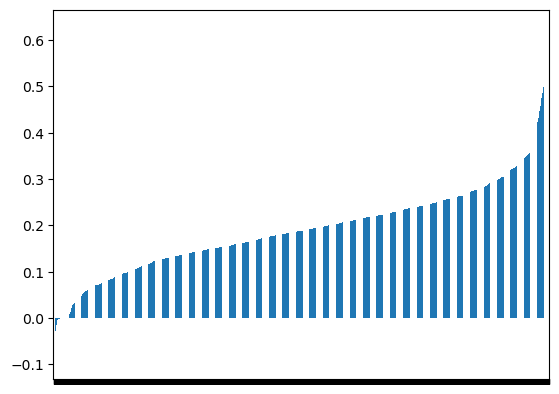

In [14]:
fig, ax = plt.subplots()
sims.sort_values().plot.bar(ax=ax)
ax.set_xticklabels([])
plt.show()

In [15]:
# sample terms
threshold = 0.99
dia_dict[sims >= threshold]

,Diagnosis Code (ICD10),Diagnosis Description (ICD10)


### Fuzzy Similarity with `thefuzz`

In [16]:
from thefuzz import fuzz

In [17]:
# Check the similarity score
def get_fuzz_similarity(term1, term2):
    """Get similarity using an NLP model."""
    if len(term2) == 0:
        return 0
    return fuzz.token_set_ratio(term1, term2)

In [19]:
tqdm.pandas()
key_term = utils.physical_exam_xa_terms[0].lower()
db_terms = dia_dict['Diagnosis Description (ICD10)'].str.lower()
sims = db_terms.progress_apply(lambda x: get_fuzz_similarity(key_term, x)) / 100

100%|███████████████████████████████████████████████| 3013/3013 [00:00<00:00, 114411.51it/s]


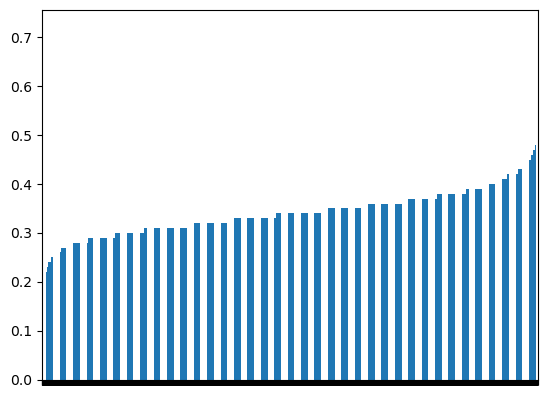

In [20]:
fig, ax = plt.subplots()
sims.sort_values().plot.bar(ax=ax)
ax.set_xticklabels([])
plt.show()

In [21]:
# sample terms
threshold = 0.91
dia_dict[sims >= threshold]

,Diagnosis Code (ICD10),Diagnosis Description (ICD10)


### Contains method

In [22]:
key_term = utils.cvd_terms[0].lower()
db_terms = dia_dict['Diagnosis Description (ICD10)'].str.lower()
matches = dia_dict[db_terms.str.contains(key_term)]
matches

,Diagnosis Code (ICD10),Diagnosis Description (ICD10)
565,I64,"Stroke, not specified as haemorrhage orinfarction"
183631,I694,"Sequelae of stroke, not specified as haemorrha..."


## `xanthomas` Candidate Physical Exam Terms from `Diagnosis` subject area

Candidate terms are generated uzing threholded token set ratio implemented by `thefuzz.fuzz`.

In [23]:
db_terms = dia_dict['Diagnosis Description (ICD10)'].str.lower()
threshold = 0.91
logger_reference = dia_dict.copy()

candidate_list = []
for key_term in tqdm(utils.physical_exam_xa_terms):
    sims = db_terms.apply(
        lambda x: get_fuzz_similarity(key_term.lower(), x)
    ) / 100
    temp = logger_reference.copy()
    temp['Score'] = sims
    temp['Key Term'] = key_term
    temp = temp[temp["Score"] >= threshold]
    candidate_list.append(temp)

candidate_terms = pd.concat(candidate_list, axis=0, ignore_index=True)
candidate_terms

100%|███████████████████████████████████████████████████████| 21/21 [00:00<00:00, 51.45it/s]


,Diagnosis Code (ICD10),Diagnosis Description (ICD10),Score,Key Term


In [24]:
candidate_terms.to_csv(
    os.path.join(PROJECT_ROOT, "results", "candidate_dia_xanthomas_terms.csv"), index=False,
)

## `xanthomas` Candidate Physical Exam Terms from `Problem List` subject area
Candidate terms are generated uzing threholded token set ratio implemented by `thefuzz.fuzz`.

In [25]:
db_terms = prl_dict['Problem Desc (Coded)'].str.lower()
threshold = 0.91
logger_reference = prl_dict.copy()

candidate_list = []
for key_term in tqdm(utils.physical_exam_xa_terms):
    sims = db_terms.apply(
        lambda x: get_fuzz_similarity(key_term.lower(), x)
    ) / 100
    temp = logger_reference.copy()
    temp['Score'] = sims
    temp['Key Term'] = key_term
    temp = temp[temp["Score"] >= threshold]
    candidate_list.append(temp)

candidate_terms = pd.concat(candidate_list, axis=0, ignore_index=True)
candidate_terms

100%|███████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.29it/s]


,Problem Code (Coded),Problem Desc (Coded),Coding Scheme (Coded),Score,Key Term
0,499478014,XANTHOMA,SN,1.00,Achilles tendon xanthoma
1,499728011,XANTHOMA,SN,1.00,Achilles tendon xanthoma
2,125555018,XANTHOMA,SN,1.00,Achilles tendon xanthoma
3,1781604017,CUTANEOUS XANTHOMA,SN,0.97,Cutaneous Xanthomas
4,499478014,XANTHOMA,SN,1.00,Tendinous Xanthoma
5,499728011,XANTHOMA,SN,1.00,Tendinous Xanthoma
6,125555018,XANTHOMA,SN,1.00,Tendinous Xanthoma
7,499478014,XANTHOMA,SN,1.00,Tendon Xanthoma
8,499728011,XANTHOMA,SN,1.00,Tendon Xanthoma
9,125555018,XANTHOMA,SN,1.00,Tendon Xanthoma


In [26]:
candidate_terms.to_csv(
    os.path.join(PROJECT_ROOT, "results", "candidate_prl_xanthomas_terms.csv"), index=False,
)

## `corneal_arcus` Candidate Physical Exam Terms from `Diagnosis` subject area

Candidate terms are generated uzing threholded token set ratio implemented by `thefuzz.fuzz`.

In [27]:
db_terms = dia_dict['Diagnosis Description (ICD10)'].str.lower()
threshold = 0.91
logger_reference = dia_dict.copy()

candidate_list = []
for key_term in tqdm(utils.physical_exam_ca_terms):
    sims = db_terms.apply(
        lambda x: get_fuzz_similarity(key_term.lower(), x)
    ) / 100
    temp = logger_reference.copy()
    temp['Score'] = sims
    temp['Key Term'] = key_term
    temp = temp[temp["Score"] >= threshold]
    candidate_list.append(temp)

candidate_terms = pd.concat(candidate_list, axis=0, ignore_index=True)
candidate_terms

100%|█████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 43.99it/s]


,Diagnosis Code (ICD10),Diagnosis Description (ICD10),Score,Key Term


In [28]:
candidate_terms.to_csv(
    os.path.join(PROJECT_ROOT, "results", "candidate_dia_corneal_arcus_terms.csv"), index=False,
)

## `corneal_arcus` Candidate Physical Exam Terms from `Problem List` subject area
Candidate terms are generated uzing threholded token set ratio implemented by `thefuzz.fuzz`.

In [29]:
db_terms = prl_dict['Problem Desc (Coded)'].str.lower()
threshold = 0.91
logger_reference = prl_dict.copy()

candidate_list = []
for key_term in tqdm(utils.physical_exam_ca_terms):
    sims = db_terms.apply(
        lambda x: get_fuzz_similarity(key_term.lower(), x)
    ) / 100
    temp = logger_reference.copy()
    temp['Score'] = sims
    temp['Key Term'] = key_term
    temp = temp[temp["Score"] >= threshold]
    candidate_list.append(temp)

candidate_terms = pd.concat(candidate_list, axis=0, ignore_index=True)
candidate_terms

100%|█████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.48it/s]


,Problem Code (Coded),Problem Desc (Coded),Coding Scheme (Coded),Score,Key Term


In [30]:
candidate_terms.to_csv(
    os.path.join(PROJECT_ROOT, "results", "candidate_prl_corneal_arcus_terms.csv"), index=False,
)

## End